# Задача
Имеются данные - временной ряд. Сделать прогноз на следующие 30 дней.

# Решение
## 1. Разведывательный анализ данных
Временной ряд представлен с детализацией по дням, всего 2190 дней:

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from skopt import BayesSearchCV
from skopt.space import Categorical, Integer, Real

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from lightgbm import LGBMRegressor
from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')


FORECAST_PERIOD = 30

Importing plotly failed. Interactive plots will not work.


In [2]:
data = pd.read_csv('./data.csv')
data

,date,y
0,2015-01-01,470481.381271
1,2015-01-02,431802.979401
2,2015-01-03,355532.336734
3,2015-01-04,477181.454626
4,2015-01-05,542685.065180
...,...,...
2185,2020-12-25,638776.950459
2186,2020-12-26,691620.666205
2187,2020-12-27,730834.495595
2188,2020-12-28,596890.075737


Проблем с отсутствующими значениями не видно:

In [3]:
print('Number of nulls in dataset: ', data['y'].isnull().sum())
print(
    'Total number of days recorded: ',
    pd.to_datetime(data['date']).max() - pd.to_datetime(data['date']).min()
)  # не должно быть меньше размера датасета - 1 

Number of nulls in dataset:  0
Total number of days recorded:  2189 days 00:00:00


У ряда нет заметного восходящего или нисходящего тренда. Возможно есть сезонность, но сходу неочевидно какая:

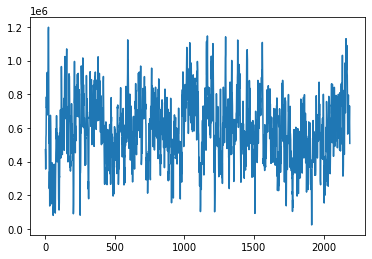

In [4]:
plt.plot(data['y'])

Проблем с выбросами также не видно:

<AxesSubplot:xlabel='y', ylabel='Density'>

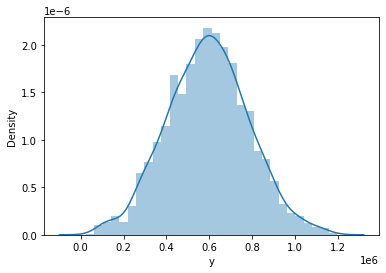

In [5]:
sns.distplot(data['y'])

## 2. Выбор модели
Начнем с простой статистической модели - экспоненциального сглаживания Хольта-Винтерса. Она поможет увидеть, как минимум, есть ли в данных сезонность и насколько она значима. В качестве целевой метрики возьмем MAPE. Оптимальные гиперпараметры для всех моделей я искал методом байесовкой оптимизации - при желании соответствующие фрагменты можно раcкомментировать и запустить: 

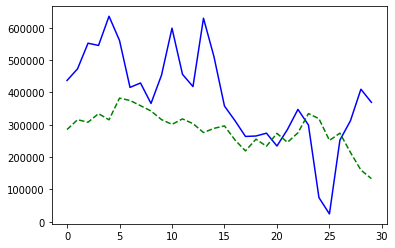

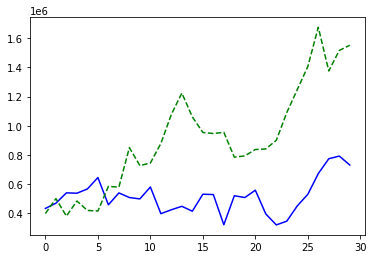

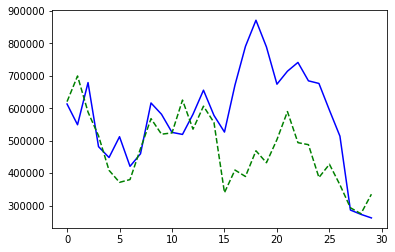

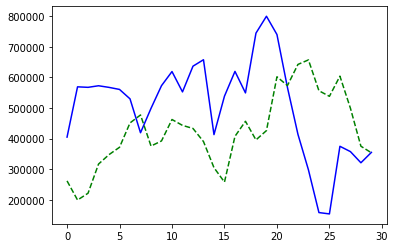

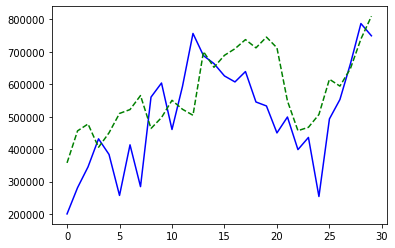

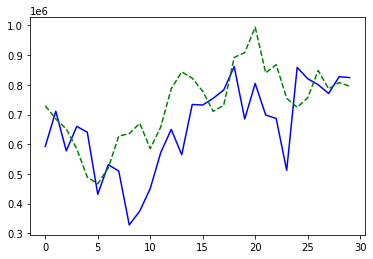

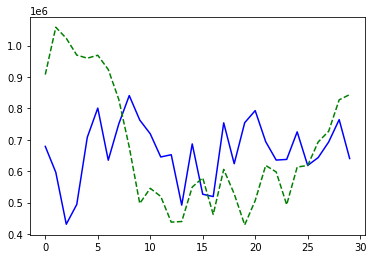

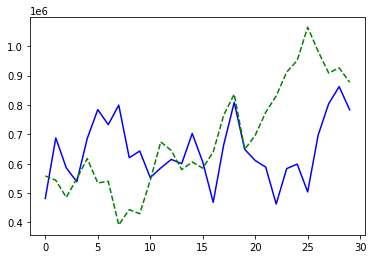

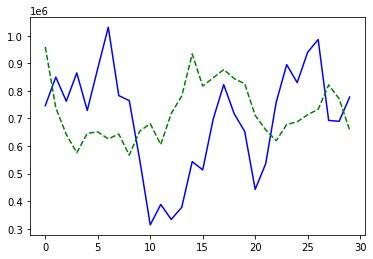

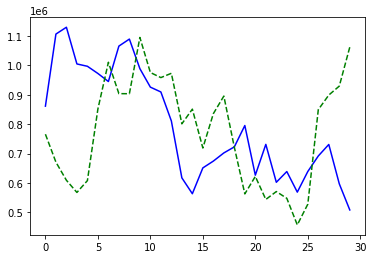

Holt-Winters best MAPE:  -0.39460148163392


In [6]:
class HoltWinters(BaseEstimator):
    def __init__(self, seasonal_periods=7, seasonal='add', trend='add', use_boxcox=False, plot_res=False):
        self.seasonal_periods = seasonal_periods
        self.seasonal = seasonal
        self.trend = trend
        self.use_boxcox = use_boxcox
        self.plot_res = plot_res
        
        
    def fit(self, X, y=None):
        self.model = ExponentialSmoothing(
            X, 
            seasonal_periods=self.seasonal_periods, 
            seasonal=self.seasonal,
            trend=self.trend,
            use_boxcox=self.use_boxcox
        ).fit()
    
    
    def predict(self, X):
        pass
    
    
    def score(self, X, y=None):
        y_hat = self.model.forecast(FORECAST_PERIOD)
        
        if self.plot_res:
            plt.plot(X, 'b-', y_hat, 'g--')
            plt.show()
        
        if np.isnan(y_hat).any():
            return -1
        return -mean_absolute_percentage_error(X, y_hat)
    

# как я оптимизировал гиперпараметры:
    
# bs = BayesSearchCV(
#     HoltWinters(),
#     search_spaces={
#         'seasonal_periods': Integer(2, 1000, prior='uniform'),
#         'seasonal': Categorical(['mul', 'add']),
#         'trend': Categorical(['mul', 'add']),
#         'use_boxcox': Categorical([True, False])
#     },
#     n_iter=50,
#     scoring=None,
#     cv=TimeSeriesSplit(n_splits=5, test_size=30),
#     random_state=0,
#     n_jobs=-1
# )
# bs.fit(data['y'].to_numpy(), y=None)
# print(bs.best_params_)


hw_results = cross_val_score(
    HoltWinters(seasonal_periods=677, seasonal='mul', trend='mul', use_boxcox=True, plot_res=True),
    X=data['y'].to_numpy(),
    y=None,
    scoring=None, 
    cv=TimeSeriesSplit(n_splits=10, test_size=30)
)
print('Holt-Winters best MAPE: ', hw_results.mean())

Хотя точность модели и нуждается в улучшении, результаты получаются вполне разумные - скорее всего в данных есть сезонность и она довольно масштабная (seasonal_periods=677).

Дальше попробуем более гибкую и универсальную модель - бустер:

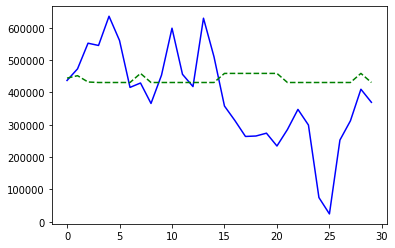

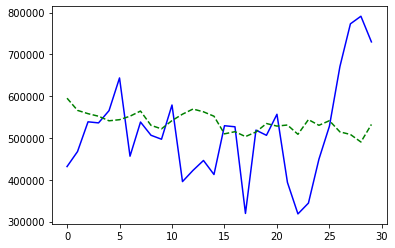

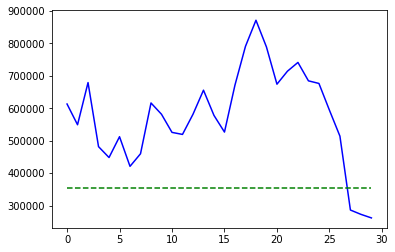

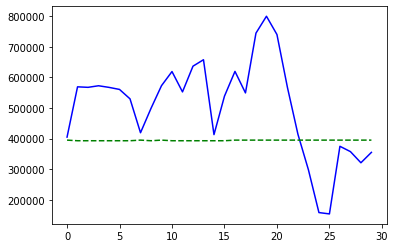

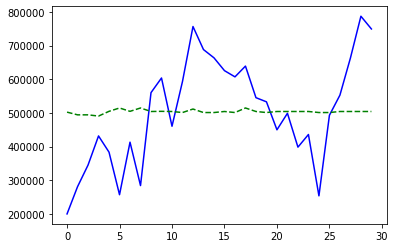

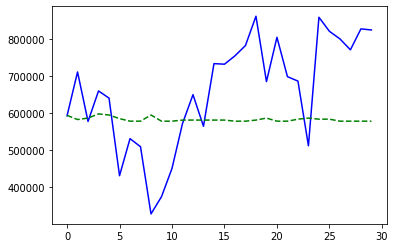

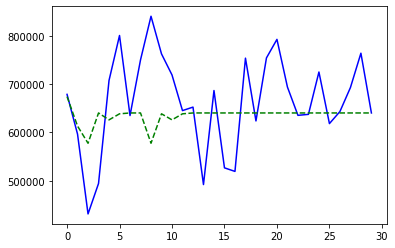

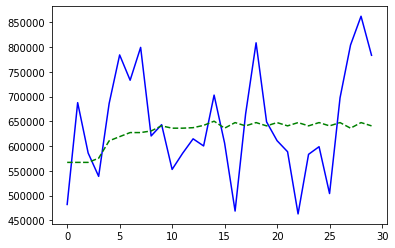

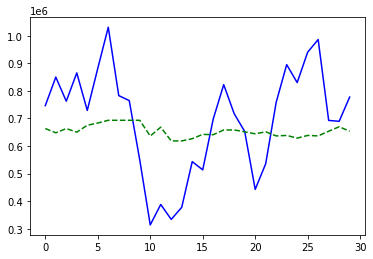

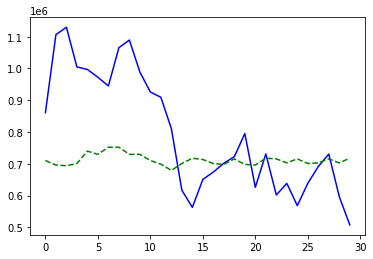

Gradient booster best MAPE:  -0.32164448957110325


In [7]:
class TSBooster(BaseEstimator):
    def __init__(
        self, 
        max_depth=2, 
        learning_rate=0.1, 
        n_estimators=100, 
        lags=10, 
        training_period=100,
        plot_res=False
    ):
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.lags = lags
        self.training_period = training_period
        self.plot_res=plot_res
        
        
    def fit(self, X, y=None):
        training_data = X[-self.training_period:]
        
        self.test_start_lags = training_data[:self.lags]
        
        lagged = pd.DataFrame({'y': training_data})
        for lag in range(1,self.lags+1):
            lagged['y_l'+str(lag)] = lagged['y'].shift(lag)
        lagged.dropna(inplace=True, axis=0)
        
        self.model = LGBMRegressor(
            max_depth=self.max_depth,
            learning_rate=self.learning_rate,
            n_estimators=self.n_estimators,
            random_state=0
        )
        self.model.fit(lagged.drop(columns=['y']), lagged['y'])
    
    
    def predict(self, X):
        pass
    
    
    def score(self, X, y=None):
        test_lags = np.flip(self.test_start_lags)
        y_hat = []
        for i in range(FORECAST_PERIOD):
            fc = self.model.predict(test_lags.reshape(1, -1))
            test_lags = np.insert(test_lags, 0, fc)[:self.lags]
            y_hat.append(fc)
        
        if self.plot_res:
            plt.plot(X, 'b-', y_hat, 'g--')
            plt.show()
            
        return -mean_absolute_percentage_error(X, y_hat)
    
    
# как я оптимизировал гиперпараметры:
    
# bs = BayesSearchCV(
#     TSBooster(),
#     search_spaces={
#         'max_depth': Integer(2, 20, prior='uniform'),
#         'learning_rate': Real(1e-4, 1e-1, prior='log-uniform'),
#         'n_estimators': Integer(10, 500, prior='log-uniform'),
#         'lags': Integer(2, 30, prior='uniform')
#     },
#     n_iter=100,
#     scoring=None,
#     cv=TimeSeriesSplit(n_splits=5, test_size=30),
#     random_state=0,
#     n_jobs=-1
# )
# bs.fit(data['y'].to_numpy(), y=None)
# print(bs.best_params_)

    
b_results = cross_val_score(
    TSBooster(lags=30, learning_rate=0.02588, max_depth=2, n_estimators=47, plot_res=True),
    X=data['y'].to_numpy(),
    y=None,
    scoring=None, 
    cv=TimeSeriesSplit(n_splits=10, test_size=30)
)
print('Gradient booster best MAPE: ', b_results.mean())

Хотя результаты улучшились, пресказание получается почти константным. Видимо, автокорреляция в пределах небольших лагов в данном случае не так важна. Учитывая это, а также наличие сезонности, следующим попробуем fbprophet: 

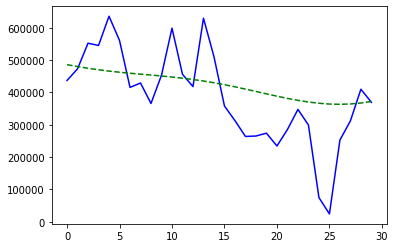

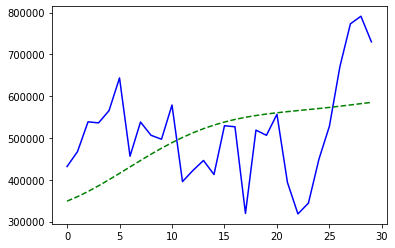

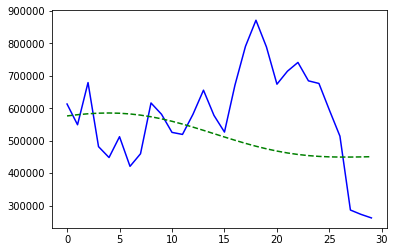

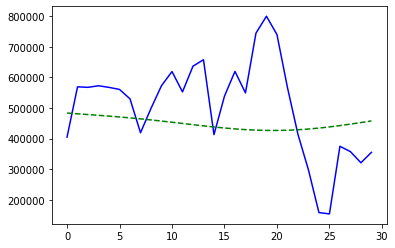

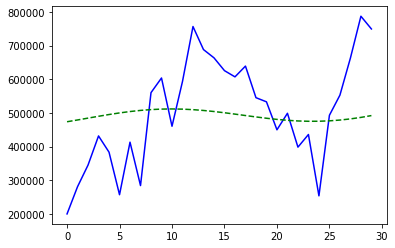

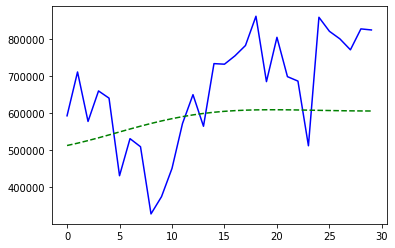

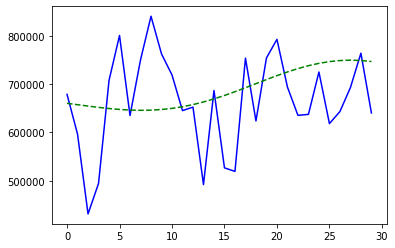

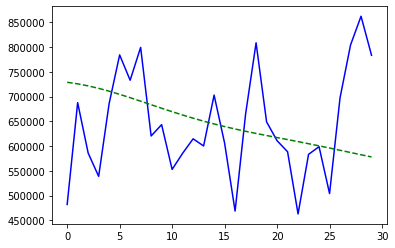

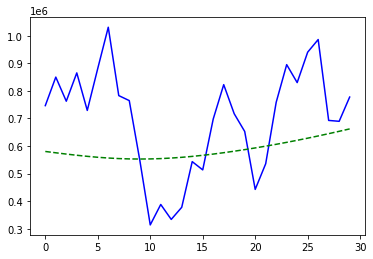

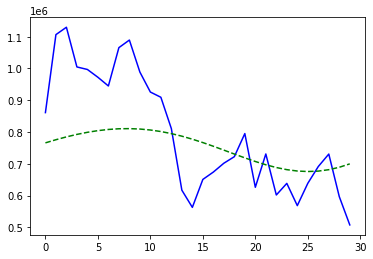

Prophet best MAPE:  -0.28896803943593213


In [8]:
# turning off annoying prophet logs, see https://github.com/facebook/prophet/issues/223#issuecomment-326455744
class suppress_stdout_stderr(object):
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        for fd in self.null_fds + self.save_fds:
            os.close(fd)


class CVProphet(BaseEstimator):
    def __init__(
        self,
        seasonality_prior_scale=10,
        c_season_period=365,
        c_season_fourier=10,
        plot_res=False
    ):
        self.seasonality_prior_scale = seasonality_prior_scale
        self.c_season_period = c_season_period
        self.c_season_fourier = c_season_fourier
        self.plot_res = plot_res
        
        
    def fit(self, X, y=None):
        self.model = Prophet(
            seasonality_mode='multiplicative',
            seasonality_prior_scale=self.seasonality_prior_scale,
            
            daily_seasonality=True,
            weekly_seasonality=False,
            yearly_seasonality=False,
            uncertainty_samples=0
        )
        self.model.add_seasonality(
            name='custom',
            period=self.c_season_period,
            fourier_order=self.c_season_fourier
        )
        
        X.columns = ['ds', 'y']
        with suppress_stdout_stderr():
            self.model.fit(X)
    
    
    def predict(self, period):
        with suppress_stdout_stderr():
            y_hat = self.model.predict(
                self.model.make_future_dataframe(periods=period)
            )['yhat'][-period:]
        return y_hat
    
    
    def score(self, X, y=None):
        y_hat = self.predict(FORECAST_PERIOD)
        
        if self.plot_res:
            plt.plot(X['y'].to_numpy(), 'b-', y_hat.to_numpy(), 'g--')
            plt.show()

        return -mean_absolute_percentage_error(X['y'].to_numpy(), y_hat)
    

# как я оптимизировал гиперпараметры:
    
# bs = BayesSearchCV(
#     CVProphet(),
#     search_spaces={
#         'seasonality_prior_scale': Integer(10, 30, prior='uniform'),
#         'c_season_period': Integer(150, 1000, prior='uniform'),
#         'c_season_fourier': Integer(10, 25, prior='uniform')
#     },
#     n_iter=100,
#     scoring=None,
#     cv=TimeSeriesSplit(n_splits=5, test_size=30),
#     random_state=0,
#     n_jobs=-1
# )
# bs.fit(data, y=None)
# print(bs.best_params_)


prophet_results = cross_val_score(
    CVProphet(
        c_season_fourier=25, 
        c_season_period=646,
        seasonality_prior_scale=28,
        plot_res=True
    ),
    X=data,
    y=None,
    scoring=None, 
    cv=TimeSeriesSplit(n_splits=10, test_size=30)
)
print('Prophet best MAPE: ', prophet_results.mean())

Как и ожидалось, точность еще улучшилась. Выберем эту модель в качестве финальной и получим прогноз.

## 3. Получение прогноза

In [9]:
model = CVProphet(c_season_fourier=25, c_season_period=646, seasonality_prior_scale=28)
model.fit(data)
preds = model.predict(FORECAST_PERIOD)
preds.name='y'
preds.reset_index(drop=True, inplace=True)
preds.to_csv('./results.csv')